In [58]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
from odc.stac import configure_rio
from dask_jobqueue import SLURMCluster
from dask.distributed import Client as daskClient
# from dask import compute as dask_compute
# from xarray import open_zarr as xr_open_zarr

from stacathome import MaxiCube

configure_rio(cloud_defaults=True, aws={"aws_unsigned": True})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Construct Cube Object

In [59]:
aoi = 'somalia'
requested_bands = ['B02', 'B03', 'B04', 'B8A']
resolution = 0.00018  # 20  # 0.00018
crs = 4326  # 32737  # 4326
chunksize_xy = 256
chunksize_t = 1000

out_path = '/Net/Groups/BGI/data/DataStructureMDI/DATA/Incoming/Sentinel/_2/S2A_L2A/ForSites/Sentinel2tiles'
os.makedirs(out_path, exist_ok=True)

zarr_store = '/Net/Groups/BGI/scratch/mzehner/VCI_Somalia/Somalia_S2_2014_2026.zarr'

mxc = MaxiCube(aoi=aoi,
               requested_bands=requested_bands,
               crs=crs,
               resolution=resolution,
               chunksize_xy=chunksize_xy,
               chunksize_t=chunksize_t,
               path=out_path,
               zarr_path=zarr_store,
               )

# this is for no longer present scenes, which are still stored in the item file
# mxc.req_items = mxc.items_local_global
# mxc.compare_local(report=True)
# mxc.items_local_global = mxc.req_items_local
# mxc.req_items = mxc.items_local_global
# mxc.compare_local(report=True)

# mxc.save_items()

len(mxc.items_local_global)

# local_ = mxc.local_assets(rerequest=True)
# len(local_)

Zarr already exists at /Net/Groups/BGI/scratch/mzehner/VCI_Somalia/Somalia_S2_2014_2026.zarr. Skipping creation. Set overwrite=True to overwrite.


76648

In [61]:
xr.open_zarr(mxc.zarr_path, mask_and_scale=False)

<xarray.Dataset> Size: 137TB
Dimensions:      (time: 3868, latitude: 75990, longitude: 58076)
Coordinates:
  * latitude     (latitude) float64 608kB 12.01 12.01 12.01 ... -1.663 -1.663
  * longitude    (longitude) float64 465kB 40.98 40.98 40.98 ... 51.44 51.44
    spatial_ref  int32 4B ...
  * time         (time) datetime64[ns] 31kB 2015-06-01 2015-06-02 ... 2026-01-01
Data variables:
    B02          (time, latitude, longitude) uint16 34TB dask.array<chunksize=(1000, 256, 256), meta=np.ndarray>
    B03          (time, latitude, longitude) uint16 34TB dask.array<chunksize=(1000, 256, 256), meta=np.ndarray>
    B04          (time, latitude, longitude) uint16 34TB dask.array<chunksize=(1000, 256, 256), meta=np.ndarray>
    B8A          (time, latitude, longitude) uint16 34TB dask.array<chunksize=(1000, 256, 256), meta=np.ndarray>

In [4]:
mxc.save_items()

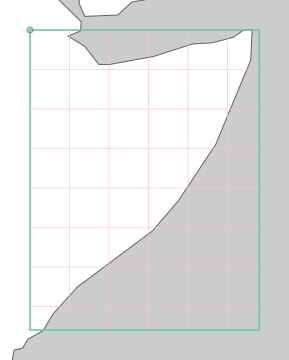

In [53]:
mxc.geobox

In [62]:
mxc.plot(subset_chunks_by=50)

In [3]:
from stacathome import load_maxicube

mxc.save()

mxc_loaded = load_maxicube(out_path + '/saved.maxicube')
mxc_loaded.req_items = mxc_loaded.items_local_global
mxc_loaded.compare_local(report=True)

All data already downloaded.


# Parallel request and download of tiles using SLURM

In [64]:
cluster = SLURMCluster(
    queue='work',                  # Specify the SLURM queue
    processes=1,                # Number of processes per job
    cores=1,                          # Number of cores per job
    memory='768MB',                    # Memory per job
    walltime='03:00:00',              # Job duration (hh:mm:ss)
)

# Scale up the number of workers
# cluster.scale(jobs=8)  # Adjust the number of jobs/workers
cluster.adapt(minimum=0, maximum=10)

# Create a Dask client that connects to the cluster
client = daskClient(cluster)

# Check cluster status
cluster

/User/homes/mzehner/micromamba/envs/minicuber/lib/python3.12/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 37027 instead
  warnings.warn(


Dashboard: http://10.0.30.56:37027/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.0.30.56:35495,Workers: 0
Dashboard: http://10.0.30.56:37027/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [ ]:
process = mxc.download_all('2015-01-01', '2024-10-31', subset=(48.53, 8.89), enlarge_by_n_chunks=5)

2024-10-11 14:08:49,846 - bokeh.server.protocol_handler - ERROR - error handling message
 message: Message 'PATCH-DOC' content: {'events': [{'kind': 'ModelChanged', 'model': {'id': 'p768542'}, 'attr': 'end', 'new': 186230.15797402582}]} 
 error: AssertionError()
Traceback (most recent call last):
  File "/User/homes/mzehner/micromamba/envs/minicuber/lib/python3.12/site-packages/bokeh/server/protocol_handler.py", line 94, in handle
    work = await handler(message, connection)
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/User/homes/mzehner/micromamba/envs/minicuber/lib/python3.12/site-packages/bokeh/server/session.py", line 295, in patch
    return connection.session._handle_patch(message, connection)
           ^^^^^^^^^^^^^^^^^^
  File "/User/homes/mzehner/micromamba/envs/minicuber/lib/python3.12/site-packages/bokeh/server/connection.py", line 65, in session
    assert self._session is not None
           ^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError
2024-10-11 14:08:49,851 - tor

In [100]:
client.close()
cluster.close()

In [57]:
mxc.save_items()
mxc.save()

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7fd0d8b1cbf0>>
Traceback (most recent call last):
  File "/User/homes/mzehner/micromamba/envs/minicuber/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


KeyboardInterrupt: 

# Load the requested data as on-the-fly xarray

In [49]:
otf_cube = mxc.load_otf_cube(subset=600, enlarge_by_n_chunks=4)
otf_cube

<xarray.Dataset> Size: 85MB
Dimensions:      (latitude: 2304, longitude: 2304, time: 2)
Coordinates:
  * latitude     (latitude) float64 18kB 11.37 11.37 11.37 ... 10.96 10.96 10.96
  * longitude    (longitude) float64 18kB 49.51 49.51 49.51 ... 49.92 49.92
    spatial_ref  int32 4B 4326
  * time         (time) datetime64[ns] 16B 2016-01-03T07:03:02.029000 2021-01...
Data variables:
    B02          (time, latitude, longitude) uint16 21MB dask.array<chunksize=(2, 256, 256), meta=np.ndarray>
    B03          (time, latitude, longitude) uint16 21MB dask.array<chunksize=(2, 256, 256), meta=np.ndarray>
    B04          (time, latitude, longitude) uint16 21MB dask.array<chunksize=(2, 256, 256), meta=np.ndarray>
    B8A          (time, latitude, longitude) uint16 21MB dask.array<chunksize=(2, 256, 256), meta=np.ndarray>

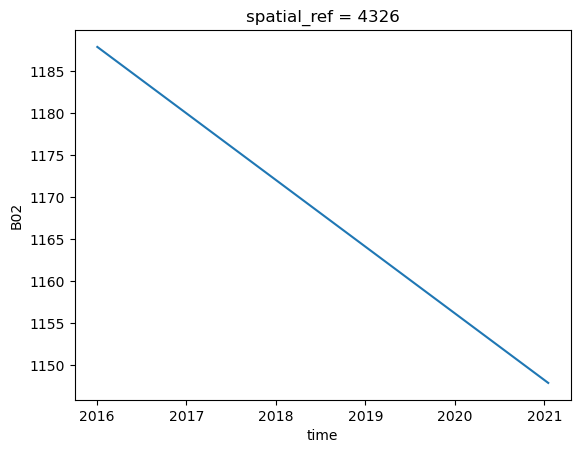

In [51]:
otf_cube.B02.mean(dim=[mxc.dimension_names['longitude'],
                  mxc.dimension_names['latitude']]).plot()

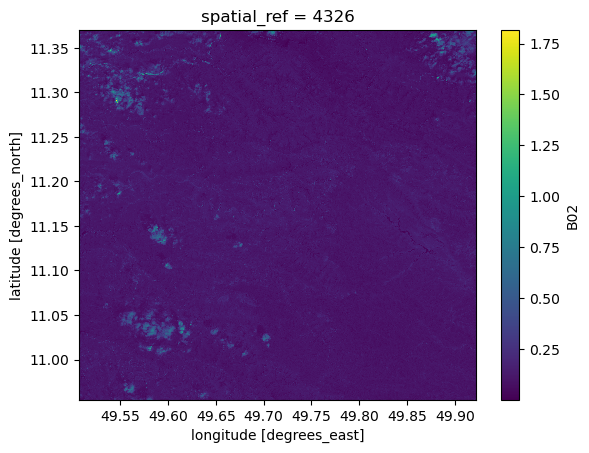

In [52]:
(otf_cube.B02.where(otf_cube.B02 != 0, np.nan).median(dim='time')/10000).plot()

# Insert data into a larger consistent cube

In [42]:
cluster = SLURMCluster(
    queue='work',                  # Specify the SLURM queue
    name='mz-worker',            # Name of the Dask worker jobs
    processes=1,                    # Number of processes per job
    cores=1,                          # Number of cores per job
    memory='1GB',                    # Memory per job
    walltime='03:00:00',              # Job duration (hh:mm:ss)
)

# Scale up the number of workers
# cluster.scale(jobs=8)  # Adjust the number of jobs/workers
cluster.adapt(minimum=0, maximum=40)

# Create a Dask client that connects to the cluster
client = daskClient(cluster)

# Check cluster status
cluster

/User/homes/mzehner/micromamba/envs/minicuber/lib/python3.12/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 42745 instead
  warnings.warn(


Dashboard: http://10.0.30.56:42745/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.0.30.56:44973,Workers: 0
Dashboard: http://10.0.30.56:42745/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [11]:
# import multiprocessing

# res = multiprocessing.Process(target=mxc.fill_large_cube, args=({'client':client})).start()

In [38]:
res = mxc.fill_large_cube()
# TODO: save the filled in times into the chunktable?

# for d in delayed_subsets:
    # mxc.chunk_table.loc[d[0], 
    #                     'timerange_in_zarr'].append([np.datetime_as_string(d[1], unit='D'),
    #                                                  np.datetime_as_string(d[2], unit='D')])
# mxc.chunk_table.loc[
#     mxc.chunk_table.
#     clip(
#         subset.boundingbox).index
#         ]['timerange_in_zarr'] = self.chunk_table.loc[
#             self.chunk_table.clip(
#                 subset.boundingbox).index
#                 ]['timerange_in_zarr'].apply(
#                     lambda x: x.append([min_time,max_time
#                                         ]))

Zarr already exists at /Net/Groups/BGI/scratch/mzehner/VCI_Somalia/Somalia_S2_2014_2026.zarr. Skipping creation. Set overwrite=True to overwrite.
Filling entire cube, this may take a while
prepare subsets


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 48.01it/s]


computing dask tasks


KeyboardInterrupt: 

In [37]:
print(res)

((0, numpy.datetime64('2021-01-01T00:00:00.000000000'), numpy.datetime64('2021-01-31T00:00:00.000000000'), 'done'), (1, numpy.datetime64('2021-01-01T00:00:00.000000000'), numpy.datetime64('2021-01-31T00:00:00.000000000'), 'done'), (2, numpy.datetime64('2021-01-01T00:00:00.000000000'), numpy.datetime64('2021-01-31T00:00:00.000000000'), 'done'), (3, numpy.datetime64('2021-01-01T00:00:00.000000000'), numpy.datetime64('2021-01-31T00:00:00.000000000'), 'done'), (4, numpy.datetime64('2021-01-01T00:00:00.000000000'), numpy.datetime64('2021-01-31T00:00:00.000000000'), 'done'), (5, numpy.datetime64('2021-01-01T00:00:00.000000000'), numpy.datetime64('2021-01-31T00:00:00.000000000'), 'done'), (6, numpy.datetime64('2021-01-01T00:00:00.000000000'), numpy.datetime64('2021-01-31T00:00:00.000000000'), 'done'), (7, numpy.datetime64('2021-01-01T00:00:00.000000000'), numpy.datetime64('2021-01-31T00:00:00.000000000'), 'done'), (8, numpy.datetime64('2021-01-01T00:00:00.000000000'), numpy.datetime64('2021-0

In [14]:
import dask
from tqdm import tqdm
import xarray as xr

from functools import partial
from stacathome.walltowall import write_otf_subset

items_gdf = mxc.items_as_geodataframe() #client.scatter(self.items_as_geodataframe())
req_chunking = {mxc.dimension_names['time']: -1,
                mxc.dimension_names['latitude']: mxc.chunksize_xy,
                mxc.dimension_names['longitude']: mxc.chunksize_xy}

t_min_large_cube = xr.open_zarr(mxc.zarr_path).time.min().values

print('prepare subsets')
partial_load_otf_subset = partial(write_otf_subset,
                                    tmin=t_min_large_cube,
                                    zarr_path=mxc.zarr_path, req_chunking=req_chunking, 
                                    dimension_names=mxc.dimension_names)
futures = []
for i in tqdm(range(100)):  # len(self.chunk_table))): 
    subset, slice_ = mxc.subset(i)
    items = items_gdf.clip(subset.boundingbox)['asset_items'].to_list()
    #subset_slice_id.append((subset, slice_, i, items))
    futures.append(dask.delayed(partial_load_otf_subset)((subset, slice_, i, items)))
    #subset_items.append((subset, items, slice, i))
    #future = client.submit(partial_load_otf_subset, (subset, slice_, i, items_gdf))
    #futures.append(future)
        
    # subset_slice_id.append((subset, slice, i))
    # delayed_write.append(delayed(partial_load_otf_subset)((subset, slice, i)))
    # delayed_write.append(delayed(partial_load_otf_subset)((subset, gdf, slice, i)))


#print('mapping dask tasks')
# partial_load_otf_subset = partial(load_otf_subset, tmin=t_min_large_cube,
#                                 zarr_path=self.zarr_path, req_chunking=req_chunking, dimension_names=self.dimension_names)
# if subdivision > 1:
#     subset_slice_id = [subset_slice_id[i:i + subdivision] for i in range(0, len(subset_slice_id), subdivision)]
#daskbag = db.from_sequence(subset_slice_id).map(partial_load_otf_subset)
# do = []
# for s in subset_slice_id[:100]:
#     do.append(dask.delayed(partial_load_otf_subset)(s))
#daskbag = db.from_delayed(delayed_write)
print('computing dask tasks')
#futures = client.gather(futures)
#wait(futures)
#print('computing dask tasks')
#_ = daskbag.compute()
res = dask.compute(*futures)

prepare subsets


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 41.75it/s]


computing dask tasks


In [39]:
client.close()
cluster.close()

# Addressing the large dataset as a minicube

In [54]:
mc_int = mxc.get_chunk(0, ('2021-01-01', '2021-01-31')).compute()
mc_int

<xarray.Dataset> Size: 16MB
Dimensions:      (time: 31, latitude: 256, longitude: 256)
Coordinates:
  * latitude     (latitude) float64 2kB 12.01 12.01 12.01 ... 11.97 11.97 11.97
  * longitude    (longitude) float64 2kB 50.75 50.75 50.75 ... 50.8 50.8 50.8
    spatial_ref  int32 4B 4326
  * time         (time) datetime64[ns] 248B 2021-01-01 2021-01-02 ... 2021-01-31
Data variables:
    B02          (time, latitude, longitude) uint16 4MB 179 174 ... 2000 2068
    B03          (time, latitude, longitude) uint16 4MB 139 135 ... 2725 2775
    B04          (time, latitude, longitude) uint16 4MB 87 92 93 ... 3547 3578
    B8A          (time, latitude, longitude) uint16 4MB 81 82 87 ... 4618 4611

In [ ]:
mc_int.B02.mean(dim=[mxc.dimension_names['latitude'],
                mxc.dimension_names['longitude']]).plot()

In [ ]:
def ndvi(band_red, band_nir):
    return (band_nir - band_red) / (band_nir + band_red)


mc_float = mc_int.where(mc_int.B02 != 0, np.nan).dropna(dim='time', how='all')
ndvi(mc_float.B04.mean(dim='time'), mc_float.B8A.mean(dim='time')).plot.imshow()

In [ ]:
mc_drop_fill = mxc.get_chunk(
    0, ('2021-01-01', '2021-01-31'), drop_fill=True).compute()
mc_drop_fill

In [ ]:
mxc.request_items('2015-01-01', '2026-01-31', subset=750, new_request=True)

In [ ]:
otf_cube = mxc.load_otf_cube(mxc.req_items_local, mxc.subset(chunk_id=750)[0])
otf_cube

In [ ]:
subset = 1070
mxc.request_items('2021-01-01', '2024-05-01', subset=subset, new_request=True)
otf_cube = mxc.load_otf_cube(
    mxc.req_items_local, subset=subset, enlarge_by_n_chunks=0, drop_fill=True)

# handle faulty downloads, maybe fixed with KeyboardInterrupt handling

In [50]:
from rasterio.windows import Window
from rasterio.errors import RasterioIOError, WarpOperationError
from rasterio import open as rio_open


def check_sentinel2_data_has_min_size(path):
    if not os.path.exists(path) or os.path.getsize(path)//1000000 > __get_filesize_mb_min(path):
        return True
    return False


def __get_filesize_mb_min(path):
    if path.endswith('10m.tif'):
        return 239
    elif path.endswith('20m.tif'):
        if path.endswith('SCL_20m.tif'):
            return 20
        else:
            return 40
    elif path.endswith('60m.tif'):
        return 58
    else:
        raise ValueError('Unknown resolution')
    

def check_assets(items):
    try:
        not_found = []
        read_failed = []
        for i in items:
            for a in i.assets:
                path = i.assets[a].href
                if not path.startswith('/Net') or not os.path.exists(path):
                    not_found.append(path)
                #elif not check_sentinel2_data_has_min_size(path):
                else:
                    try:
                        src = rio_open(path)
                        src.read(1, window=Window(src.width-256, src.height-256, 
                                                  src.width, src.height))
                    except (RasterioIOError, WarpOperationError, Exception) as e:
                        read_failed.append(path)
        #return None
        return not_found, read_failed
    except Exception as e:
        return e

In [41]:
#check_assets(mxc.items_local_global[:10])
subdivision=20
sliced_items = [mxc.items_local_global[i:i + subdivision] 
                for i in range(0, len(mxc.items_local_global), subdivision)]


In [51]:
from tqdm import tqdm
import dask
from dask.distributed import wait
# this will take a while, but failed in SLURM
res_2 = []
for i in tqdm(sliced_items):
    res_2.append(dask.delayed(check_assets)(i))


res_2 = dask.compute(*res_2)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 962/962 [00:00<00:00, 10183.72it/s]
/User/homes/mzehner/micromamba/envs/minicuber/lib/python3.12/site-packages/distributed/client.py:3361: UserWarning: Sending large graph of size 54.48 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


In [47]:
not_found, read_failed = [], []
for r in res_2:
    if len(r[0]) > 0:
        not_found.extend(r[0])
    if len(r[1]) > 0:
        read_failed.extend(r[1])

for i in not_found:
    if os.path.exists(i):
        print(i, os.path.getsize(i)//1000000)
    else:
        print('not exist:', i)

S2A_MSIL2A_20240622T070631_R106_T38PQS_20240622T113053 B03 227
S2A_MSIL2A_20230916T070621_R106_T38PQT_20230916T131828 B03 208
S2A_MSIL2A_20210116T070231_R063_T39PUK_20210116T213533 B03 103
S2A_MSIL2A_20210116T070231_R063_T39PUN_20210116T214132 B03 117
S2B_MSIL2A_20210107T072259_R006_T37NHC_20210121T094333 B02 148
S2A_MSIL2A_20210122T072211_R006_T37NHA_20210131T153302 B03 108
S2A_MSIL2A_20210126T070151_R063_T38NQL_20210126T181022 B02 56
S2A_MSIL2A_20210112T072251_R006_T38PNR_20210112T211157 B03 69
S2B_MSIL2A_20210121T070209_R063_T38NRM_20210122T122217 B03 79
S2B_MSIL2A_20210107T072259_R006_T37NHC_20210121T094333 B02 148


In [52]:
ids = [i.id for i in mxc.items_local_global]
empty_items = []
for i in read_failed[:10]:
    if os.path.exists(i):
        path_sep = i.split('/')
        item_name = path_sep[-6]
        item_name = item_name[:27] + item_name[33:-5]
        asset = path_sep[-1][-11:-8]
        print(item_name, asset, os.path.getsize(i)//1000000)

        try:
            pos = ids.index(item_name)
            if asset in mxc.items_local_global[pos].assets:
                del mxc.items_local_global[pos].assets[asset]
                if len(mxc.items_local_global[pos].assets) == 0:
                    empty_items.append(pos)
        except ValueError:
            continue

        os.remove(i)
    else:
        print('not exist:', i)

S2A_MSIL2A_20240622T070631_R106_T38PQS_20240622T113053 B03 227
S2A_MSIL2A_20230916T070621_R106_T38PQT_20230916T131828 B03 208
S2A_MSIL2A_20210116T070231_R063_T39PUK_20210116T213533 B03 103
S2A_MSIL2A_20210116T070231_R063_T39PUN_20210116T214132 B03 117
S2B_MSIL2A_20210107T072259_R006_T37NHC_20210121T094333 B02 148
S2A_MSIL2A_20210122T072211_R006_T37NHA_20210131T153302 B03 108
S2A_MSIL2A_20210126T070151_R063_T38NQL_20210126T181022 B02 56
S2A_MSIL2A_20210112T072251_R006_T38PNR_20210112T211157 B03 69
S2B_MSIL2A_20210121T070209_R063_T38NRM_20210122T122217 B03 79
not exist: /Net/Groups/BGI/data/DataStructureMDI/DATA/Incoming/Sentinel/_2/S2A_L2A/ForSites/Sentinel2tiles/S2B_MSIL2A_20210107T072259_N0212_R006_T37NHC_20210121T094333.SAFE/GRANULE/L2A_T37NHC_A020052_20210107T073543/IMG_DATA/R10m/T37NHC_20210107T072259_B02_10m.tif


In [56]:
for i in empty_items[::-1]:
    del mxc.items_local_global[i]

In [57]:
len(mxc.items_local_global)

19224

In [49]:
len(read_failed)

2144

In [34]:
read_failed[0]

'/Net/Groups/BGI/data/DataStructureMDI/DATA/Incoming/Sentinel/_2/S2A_L2A/ForSites/Sentinel2tiles/S2A_MSIL2A_20240622T070631_N0510_R106_T38PQS_20240622T113053.SAFE/GRANULE/L2A_T38PQS_A047007_20240622T072626/IMG_DATA/R10m/T38PQS_20240622T070631_B03_10m.tif'

In [ ]:
import os
import rasterio

def is_valid_tiff_rasterio(file_path):
    try:
        with rasterio.open(file_path) as src:
            src.read(1)  # Try reading the first band
        return True
    except (rasterio.errors.RasterioIOError, Exception) as e:
        print(f"Error with file {file_path}: {e}")
        return False

def check_tiff_files_recursively_rasterio(directory):
    valid_files = []
    invalid_files = []

    for root, _, files in tqdm(os.walk(directory)):
        for file in files:
            if file.endswith(('.tif', '.tiff')):
                file_path = os.path.join(root, file)
                if is_valid_tiff_rasterio(file_path):
                    valid_files.append(file_path)
                else:
                    invalid_files.append(file_path)

    return valid_files, invalid_files

# Example usage
directory = out_path
valid_tiffs, invalid_tiffs = check_tiff_files_recursively_rasterio(directory)

print("Valid TIFFs:", valid_tiffs)
print("Invalid TIFFs:", invalid_tiffs)

In [ ]:
from tqdm import tqdm
import logging
import io

from stacathome.walltowall import _load_otf_cube_bulk
from rasterio.errors import WarpOperationError

gdf = mxc.items_as_geodataframe()

log_stream = io.StringIO()
logging.basicConfig(level=logging.ERROR, stream=log_stream, format='%(levelname)s:%(message)s')
e_msg = []
for i in tqdm([10000]):  # range(0, len(mxc.chunk_table), 5500)):
    subset, _ = mxc.subset(i)


    items = gdf.clip(subset.boundingbox)['asset_items'].to_list()

    if len(items) == 0:
        continue

    cube = _load_otf_cube_bulk(subset=subset, 
                               filtered_items=items, 
                               requested_bands=None)

    try:
        cube.mean(dim=[mxc.dimension_names['latitude'], 
                       mxc.dimension_names['longitude']]).compute()
        # cube.compute() 
    except WarpOperationError as e:
        pass
    #    print(i)
    # print(log_stream.getvalue())
logged_message = log_stream.getvalue()
log_stream.close()
logged_message

msgs = logged_message.split('\n')
erred_scenes = []
for m in msgs:
    if m.startswith('ERROR:Aborting load due to failure while reading:'):
        erred_scenes.append(m.split(' ')[-1].split(':')[0])
erred_scenes = set(erred_scenes)

ids = [i.id for i in mxc.items_local_global]
empty_items = []

for i in erred_scenes:
    path_sep = i.split('/')
    item_name = path_sep[-6]
    item_name = item_name[:27] + item_name[33:-5]
    asset = path_sep[-1][-11:-8]
    print(item_name, asset)
    # try:
    #     pos = ids.index(item_name)
    #     if asset in mxc.items_local_global[pos].assets:
    #         del mxc.items_local_global[pos].assets[asset]
    #         if len(mxc.items_local_global[pos].assets) == 0:
    #             empty_items.append(pos)
    # except ValueError:
    #     continue
